# 全モデル・全データセットの結果比較

このノートブックでは、各データセット（NiB、SM、BH）に対して、各モデル（bayes、gpr、optuna_tpe）でseed1～5の結果を集計し、平均と分散をプロットします。

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# グラフのスタイル設定
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")

## データの読み込みと集計

In [18]:
# 実験の設定
datasets = ['NiB', 'SM', 'BH']
models = ['bayes_10rounds_10trials', 'gpr_100trials', 'optuna_tpe_100trials']
model_labels = ['ReactionT5 BO', 'GPR BO', 'Optuna TPE']
seeds = [1, 2, 3, 4, 5]
runs_dir = Path('../runs')

print(f"データセット: {datasets}")
print(f"モデル: {model_labels}")
print(f"シード: {seeds}")

データセット: ['NiB', 'SM', 'BH']
モデル: ['ReactionT5 BO', 'GPR BO', 'Optuna TPE']
シード: [1, 2, 3, 4, 5]


In [19]:
import sqlite3

def load_optimization_log(model, dataset, seed):
    """
    最適化ログを読み込む
    
    Args:
        model: モデル名
        dataset: データセット名
        seed: シード番号
    
    Returns:
        DataFrame: 最適化ログ
    """
    run_name = f"{model}_{dataset}_seed{seed}"
    
    # optuna_tpeの場合はDBから読み込み
    if 'optuna_tpe' in model:
        db_path = runs_dir / run_name / f"{run_name}.db"
        if not db_path.exists():
            print(f"Warning: {db_path} not found")
            return None
        
        try:
            conn = sqlite3.connect(str(db_path))
            # trial number と value (yield) を取得
            query = """
            SELECT t.number as trial, tv.value as actual_yield
            FROM trials t
            JOIN trial_values tv ON t.trial_id = tv.trial_id
            ORDER BY t.number
            """
            df = pd.read_sql_query(query, conn)
            conn.close()
            
            # trial番号を1始まりに調整
            df['trial'] = df['trial'] + 1
            df['model'] = model
            df['dataset'] = dataset
            df['seed'] = seed
            return df
        except Exception as e:
            print(f"Error loading {db_path}: {e}")
            return None
    else:
        # ReactionT5, gprの場合はCSVから読み込み
        log_path = runs_dir / run_name / "optimization_log.csv"
        
        if not log_path.exists():
            print(f"Warning: {log_path} not found")
            return None
        
        try:
            df = pd.read_csv(log_path)
            
            df['model'] = model
            df['dataset'] = dataset
            df['seed'] = seed
            return df
        except Exception as e:
            print(f"Error loading {log_path}: {e}")
            return None

# 全データを読み込み
all_logs = []

for dataset in datasets:
    for model in models:
        for seed in seeds:
            df = load_optimization_log(model, dataset, seed)
            if df is not None:
                all_logs.append(df)

# 全データを結合
if all_logs:
    combined_df = pd.concat(all_logs, ignore_index=True)
    print(f"\n読み込み完了: {len(all_logs)} ファイル, 合計 {len(combined_df)} レコード")
    print(f"\nデータセット別カウント:")
    print(combined_df.groupby(['dataset', 'model', 'seed']).size().unstack(fill_value=0))
else:
    print("データが読み込めませんでした")


読み込み完了: 45 ファイル, 合計 5000 レコード

データセット別カウント:
seed                               1    2    3    4    5
dataset model                                           
BH      bayes_10rounds_10trials  100  100  100  100  100
        gpr_100trials            100  100  100  100  100
        optuna_tpe_100trials     100  100  100  100  100
NiB     bayes_10rounds_10trials  200  200  200  200  200
        gpr_100trials            100  100  100  100  100
        optuna_tpe_100trials     100  100  100  100  100
SM      bayes_10rounds_10trials  100  100  100  100  100
        gpr_100trials            100  100  100  100  100
        optuna_tpe_100trials     100  100  100  100  100


In [ ]:
# 各モデル・データセット・シードごとの統計を計算
stats_list = []

for dataset in datasets:
    for model in models:
        for seed in seeds:
            df_subset = combined_df[
                (combined_df['dataset'] == dataset) & 
                (combined_df['model'] == model) & 
                (combined_df['seed'] == seed)
            ].copy()
            
            if len(df_subset) > 0:
                # trialでソート
                if 'trial' in df_subset.columns:
                    df_subset = df_subset.sort_values('trial')
                
                # 累積最大収率を計算
                cumulative_max = df_subset['actual_yield'].cummax()
                
                stats = {
                    'dataset': dataset,
                    'model': model,
                    'seed': seed,
                    'max_yield': df_subset['actual_yield'].max(),
                    'mean_yield': df_subset['actual_yield'].mean(),
                    'final_best_yield': cumulative_max.iloc[-1],
                    'n_trials': len(df_subset),
                    'mae': np.abs(df_subset['error_pct']).mean() if 'error_pct' in df_subset.columns else np.nan
                }
                stats_list.append(stats)

stats_df = pd.DataFrame(stats_list)
print("統計量の計算完了")
print(f"\n各モデルの試行数:")
print(stats_df.groupby(['dataset', 'model'])['n_trials'].first().unstack(fill_value=0))
print("\n")
stats_df.head(10)

## Optimization Progress Comparison

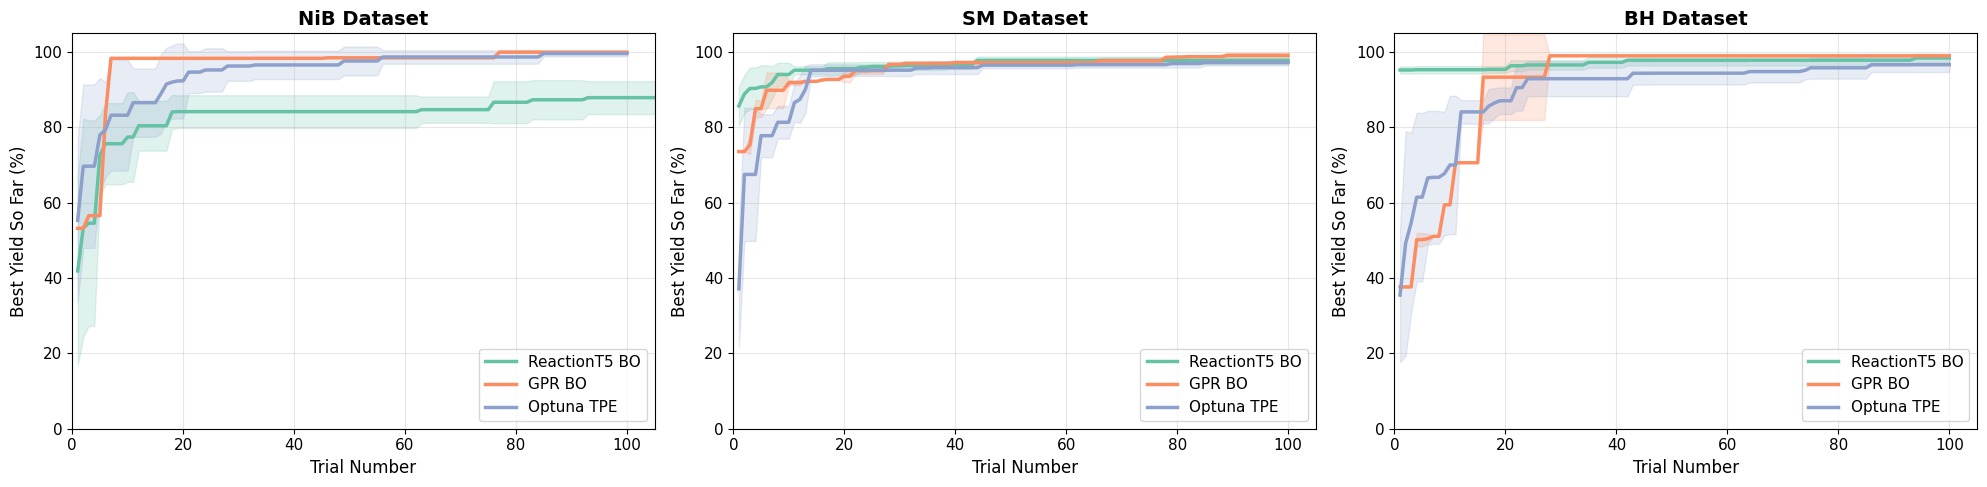

Optimization Progress比較プロット完了


In [22]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

for i, dataset in enumerate(datasets):
    ax = axes[i]
    
    for j, (model, model_label) in enumerate(zip(models, model_labels)):
        # 各seedの進捗データを集める
        all_progress = []
        
        for seed in seeds:
            df_subset = combined_df[
                (combined_df['dataset'] == dataset) & 
                (combined_df['model'] == model) & 
                (combined_df['seed'] == seed)
            ].copy()
            
            if len(df_subset) > 0:
                # trialでソート
                if 'trial' in df_subset.columns:
                    df_subset = df_subset.sort_values('trial')
                
                # 累積最大値を計算（それまでに得られた最大収率）
                cumulative_max = df_subset['actual_yield'].cummax().values
                all_progress.append(cumulative_max)
        
        if all_progress:
            # 全seedの長さを確認して揃える
            lengths = [len(p) for p in all_progress]
            if len(set(lengths)) > 1:
                print(f"Info: {dataset} {model_label} lengths: {set(lengths)} - using minimum")
                min_len = min(lengths)
                all_progress = [p[:min_len] for p in all_progress]
            
            # 全seedの平均と標準偏差を計算
            all_progress = np.array(all_progress)
            mean_progress = np.mean(all_progress, axis=0)
            std_progress = np.std(all_progress, axis=0)
            trials = np.arange(1, len(mean_progress) + 1)
            
            # プロット: 平均を線で、標準偏差を塗りつぶしで
            ax.plot(trials, mean_progress, label=f'{model_label}', 
                   linewidth=2.5, color=colors[j])
            ax.fill_between(trials, 
                           mean_progress - std_progress,
                           mean_progress + std_progress,
                           alpha=0.2, color=colors[j])
    
    ax.set_title(f'{dataset} Dataset', fontsize=14, fontweight='bold')
    ax.set_xlabel('Trial Number', fontsize=12)
    ax.set_ylabel('Best Yield So Far (%)', fontsize=12)
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 105])
    ax.set_xlim([0, 105])

plt.tight_layout()
plt.savefig('../runs/comparison_optimization_progress.png', dpi=300, bbox_inches='tight')
plt.show()

print("Optimization Progress比較プロット完了")